In [1]:
import numpy as np
import moviepy.editor as mp
import opensmile
import pandas as pd
import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import matplotlib
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score,classification_report

In [2]:
# %%capture
# clip = mp.VideoFileClip(r"D:\Speech Emotion Recognition\Speech-Emotion-Detection\data\trimmed_hindi\S03\S03_hin_f_admi_a_a.mov");
 
# # Insert Local Audio File Path
# clip.audio.write_audiofile(r"D:\Speech Emotion Recognition\Speech-Emotion-Detection\something.wav");

In [3]:
hindidatafilepath = r"D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\data\\trimmed_hindi\\"
speakerID =  os.listdir(hindidatafilepath) #stores the speaker IDs

## Creating the wav files

1. High Activation: Admiration (1), Surprise, Arrogance, Contempt, Irritation  

2. Moderate Activation (0): Irony, Seductiveness, Authority, Doubt, Uncertainty  

3. Low Activation (-1): Politeness, Neutral Question, Neutral Statement, Sincerity, Obviousness, Walking-on-Eggs. 

In [4]:
%%capture 
#supressing mp class outputs(too big)
file_attitude = []
file_activation = [] #activation based classification
file_valence = [] #valence based classification
file_dominance = [] #dominance based classification
file_path = []
sentence_identity = []
speaker_identity = []
os.makedirs("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav")#making the required file directory
for fileDir in speakerID:
  os.makedirs("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir)
  for file in os.listdir(hindidatafilepath + fileDir+"\\"):
    clipinstance = mp.VideoFileClip(hindidatafilepath + fileDir+"\\"+file)
    clipinstance.audio.write_audiofile("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
    file_path.append("D:\\Speech Emotion Recognition\\Speech-Emotion-Detection\\data\\trimmed_hindi_wav\\"+fileDir+"\\"+file[:-4]+".wav")
    file_attitude.append(file[10:14]) #label of attitude 4 letter symbol
    sentence_identity.append(file[15]) #sentence labels could be 'a' and 'b'
    speaker_identity.append(file[0:3])
    #getting the activations based on attitudes from each utterance 3 (+1 - high, 0 - moderate, -1 - low)
    if file[10:14].lower() in ["admi", "surp", "arro", "cont", "irri"]:
      file_activation.append(1)#denotes high activation
    elif file[10:14].lower() in ["iron" , "sedu" , "auth" , "doub" , "unce"]:
      file_activation.append(0)
    else:
      file_activation.append(-1)

    if file[10:14].lower() in ["admi" , "surp", "sedu"]:
      file_valence.append("pos")
    elif file[10:14].lower() in ["decl", "ques", "poli", "sinc", "woeg"]:
      file_valence.append("neu")
    elif file[10:14].lower() in ["iron", "auth", "doub", "obvi"]:
      file_valence.append("mix")
    else:
      file_valence.append("neg")

    #dominance based classification
    if file[10:14].lower() in ["auth", "arro", "cont"]:
      file_dominance.append(1)
    elif file[10:14].lower() in ["poli", "decl", "ques", "sinc", "unce", "woeg"]:
      file_dominance.append(-1)
    else:
      file_dominance.append(0)


In [5]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [6]:
data, sampling_rate = librosa.load(file_path[0])
max_length = len(data)
df = smile.process_signal(
    data,
    sampling_rate
)
for audioFile in file_path[1:]: 
  data, sampling_rate = librosa.load(audioFile)
  if len(data)>= max_length:#finding maximum length across all the utterances
    max_length = len(data)
  df = pd.concat([df, smile.process_signal(
    data,
    sampling_rate
)])

In [7]:
X = df.to_numpy() #no_of_samples x 88...no_of_samples = 512, 8 speakers, each has 16 attitudes and 2 sentences spoken twice per attitude


In [8]:
y_atti = file_attitude
y_valence = file_valence
y_dominance = file_dominance
y_activation = file_activation

In [9]:
class StandardScaleNormalizer():

    def fit(self, X, speaker):
        """Fits the normalization on input data wrt each of the speaker

        Args:
            X (_type_): _description_
            y_attitude (_type_): _description_
            speaker (_type_): _description_
        """
        speakerID = set(speaker) #generates the unique speaker IDs
        dictMean, dictStd = {}, {}
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        for id in speakerID:
            df_speaker = df.loc[df["speakerID"] == id]
            dictMean[id] = df_speaker.mean()
            dictStd[id] = df_speaker.std()
            
        self.mean = dictMean
        self.scale = dictStd
        
    def transform(self, X, speaker):
        speakerID = set(speaker) #generates the unique speaker IDs
        df = pd.DataFrame(X)
        df["speakerID"]=speaker
        df_copy = df.copy()
        for id in speakerID:
            df_copy.loc[df_copy["speakerID"] == id] = (df_copy.loc[df_copy["speakerID"] == id]-self.mean[id])/self.scale[id]
        return df_copy.drop(["speakerID"], axis=1)

    def fit_transform(self, X, speaker):
        self.fit(X, speaker)
        df_copy = self.transform(X, speaker)
        return df_copy


In [130]:
class sampleTrainTest():    
    
    def sample(self, X, y, speaker, train_size, seed):
        #X is n_samples x n_features
        y_unique = dict(collections.Counter(y))
        self.trainsize = int((train_size)*y_unique[min(y_unique, key=y_unique.get)])
        df = pd.DataFrame(X)
        df["label"] = y
        df["speakerID"] = speaker
        train_data = pd.DataFrame()
        test_data = pd.DataFrame()
        for id in list(set(y_activation)):
            data_iterable_train, data_iterable_test = train_test_split(df.loc[df["label"]==id], train_size=self.trainsize, random_state=seed)
            train_data = pd.concat([train_data,data_iterable_train])
            test_data = pd.concat([test_data,data_iterable_test])
               
        y_train, y_test, speaker_identity_train, speaker_identity_test = train_data["label"], test_data["label"], train_data["speakerID"], test_data["speakerID"]
        train_data = train_data.drop(["label", "speakerID"], axis = 1)
        test_data = test_data.drop(["label", "speakerID"], axis = 1)
        X_train, X_test = train_data.to_numpy(), test_data.to_numpy()
        return X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test

In [131]:
sampleMe = sampleTrainTest()
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = sampleMe.sample(X, y_activation, speaker_identity, train_size=0.9, seed=42)

In [132]:
X_train.shape

(432, 88)

## Activation based classification

In [98]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_activation, speaker_identity, test_size=0.33, random_state=42)

In [133]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([57, 56, 51, 54, 58, 53, 53, 50])

In [134]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total

{0: 144, 1: 144, -1: 144}

In [135]:
StandardScaleNormalizerObj = StandardScaleNormalizer()
X_train_norm = StandardScaleNormalizerObj.fit_transform(X_train, speaker_identity_train)
X_test_norm = StandardScaleNormalizerObj.transform(X_test, speaker_identity_test)

In [136]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 10, 100], 
              'gamma': [1,0.1, 0.01],
               'kernel': ['rbf']} 


# param_grid = {'C': [ 1, 10, 100, 1000,10000], 
#               'gamma': [5,1,0.1,0.01,0.001,0.0001],
#               'kernel': ['linear','rbf']} 

  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [137]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [138]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 38.19%


In [139]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 50.00%


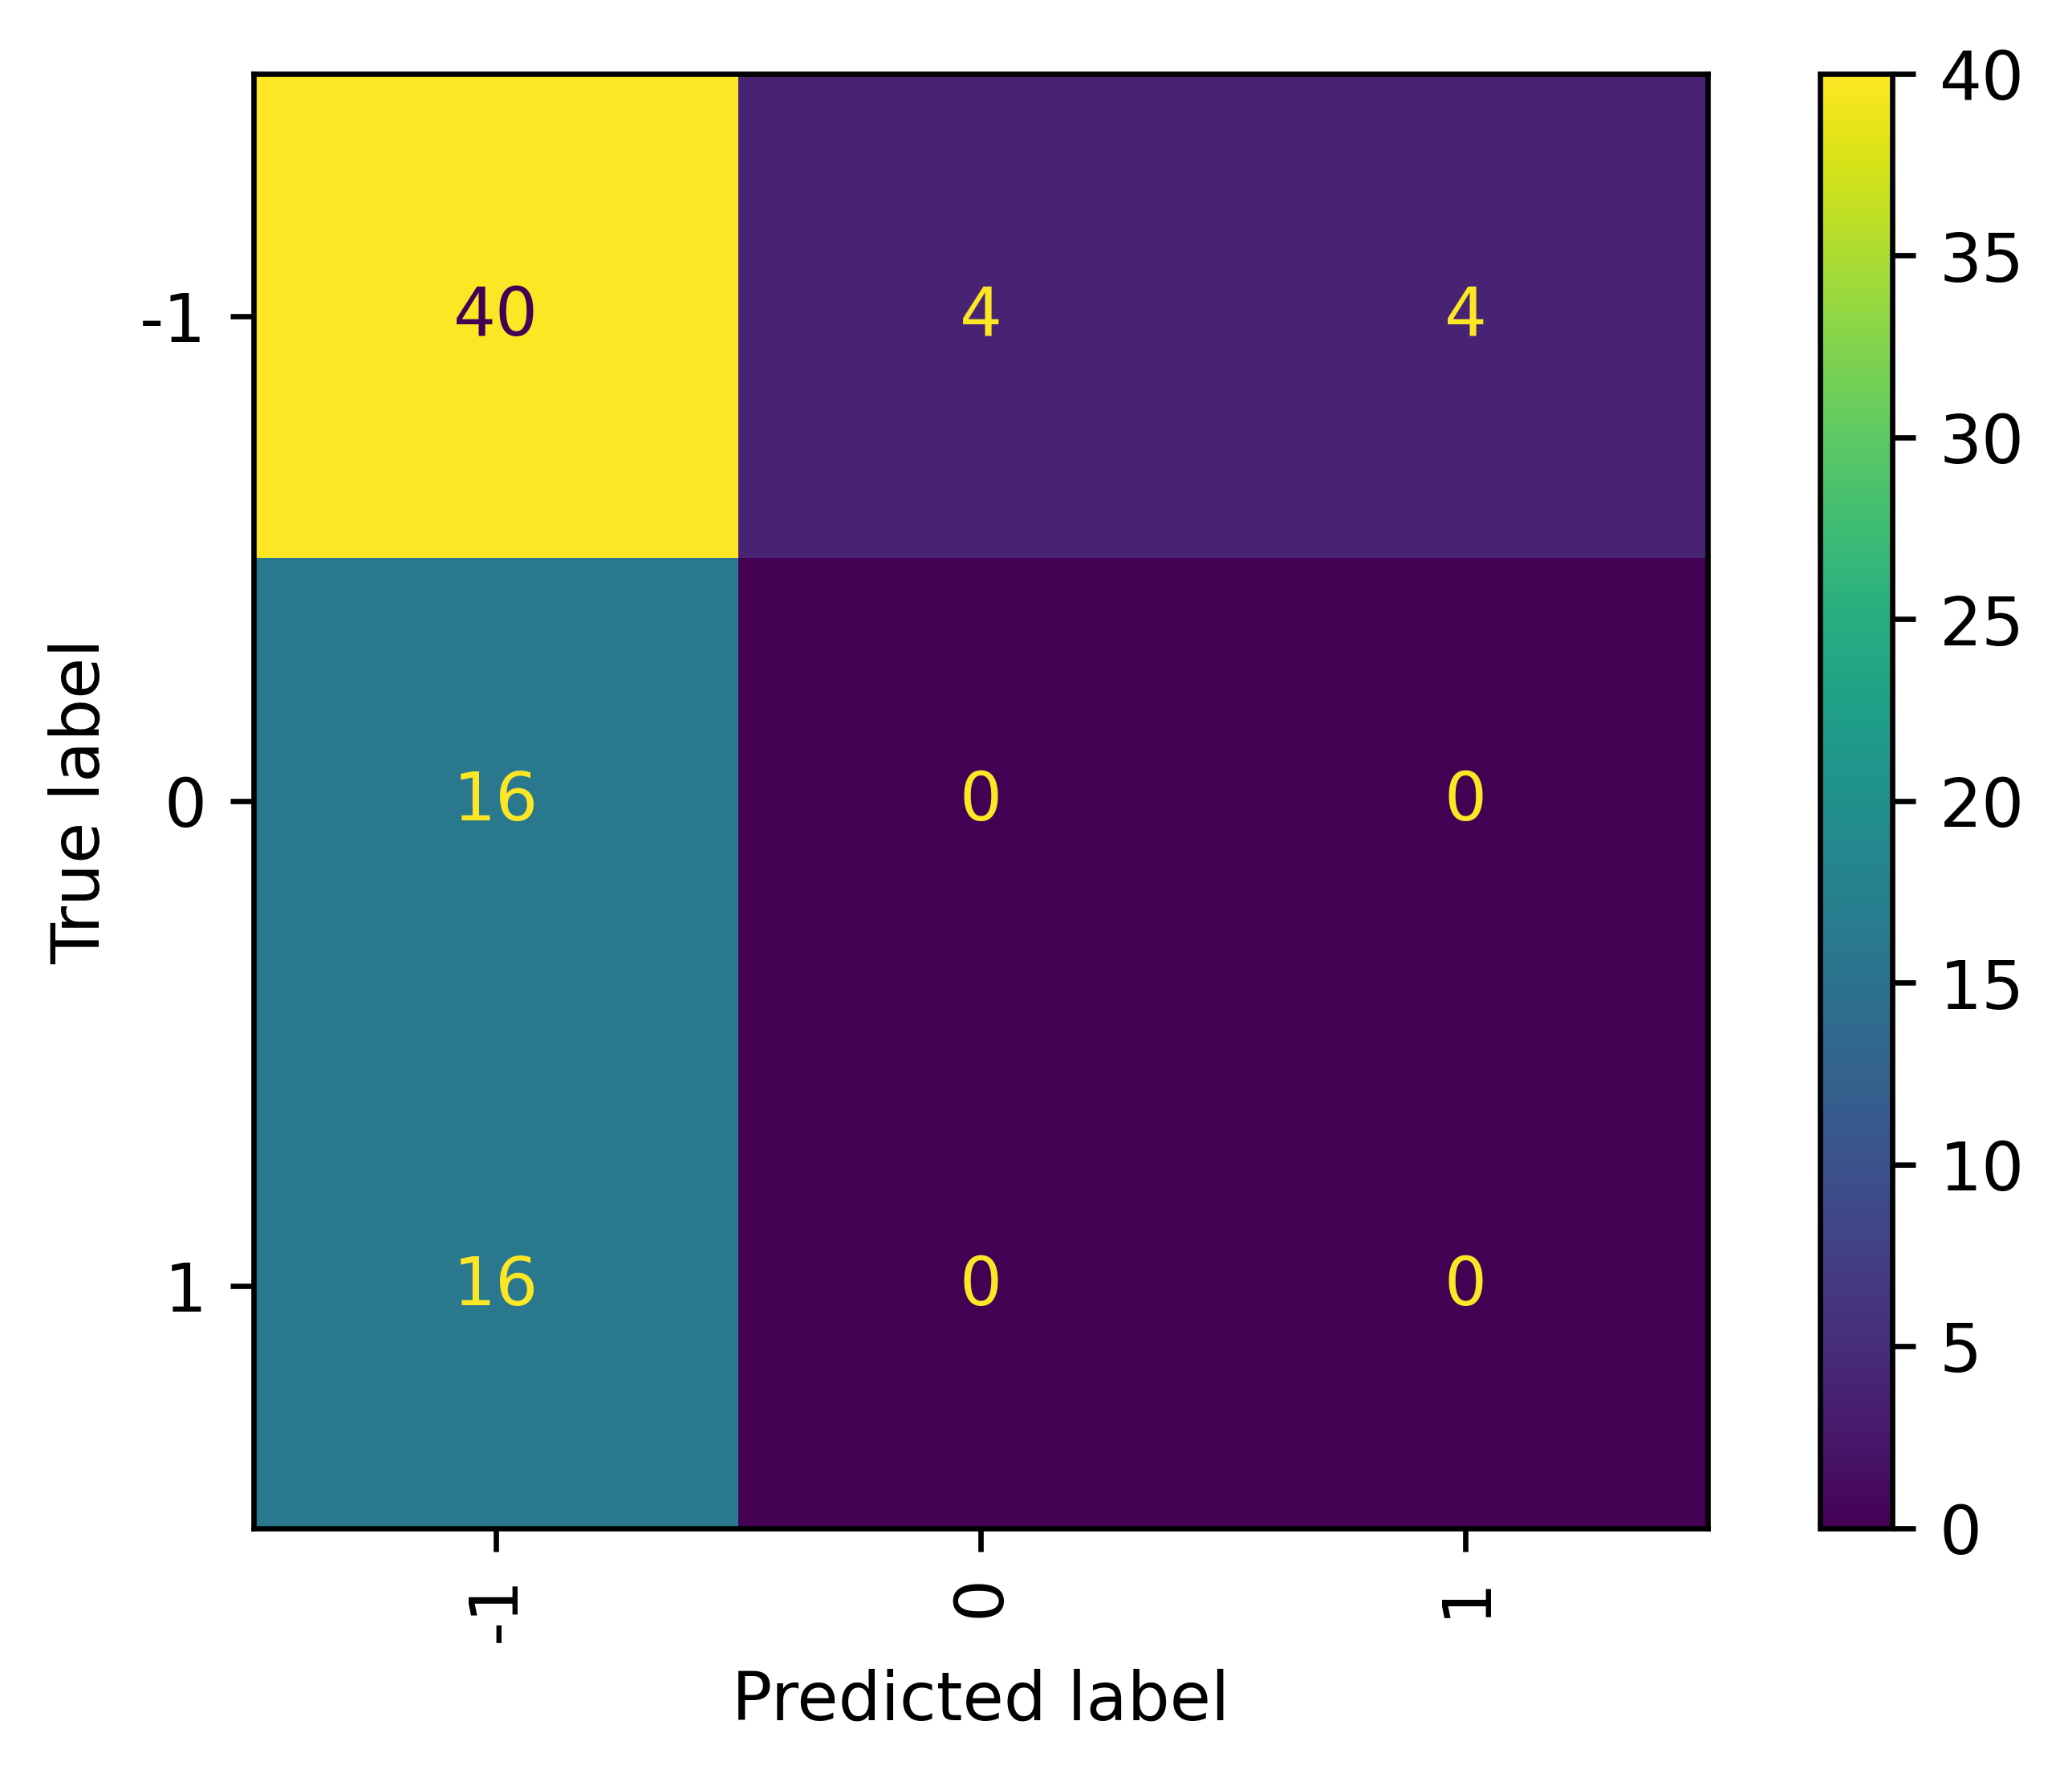

In [140]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.show()

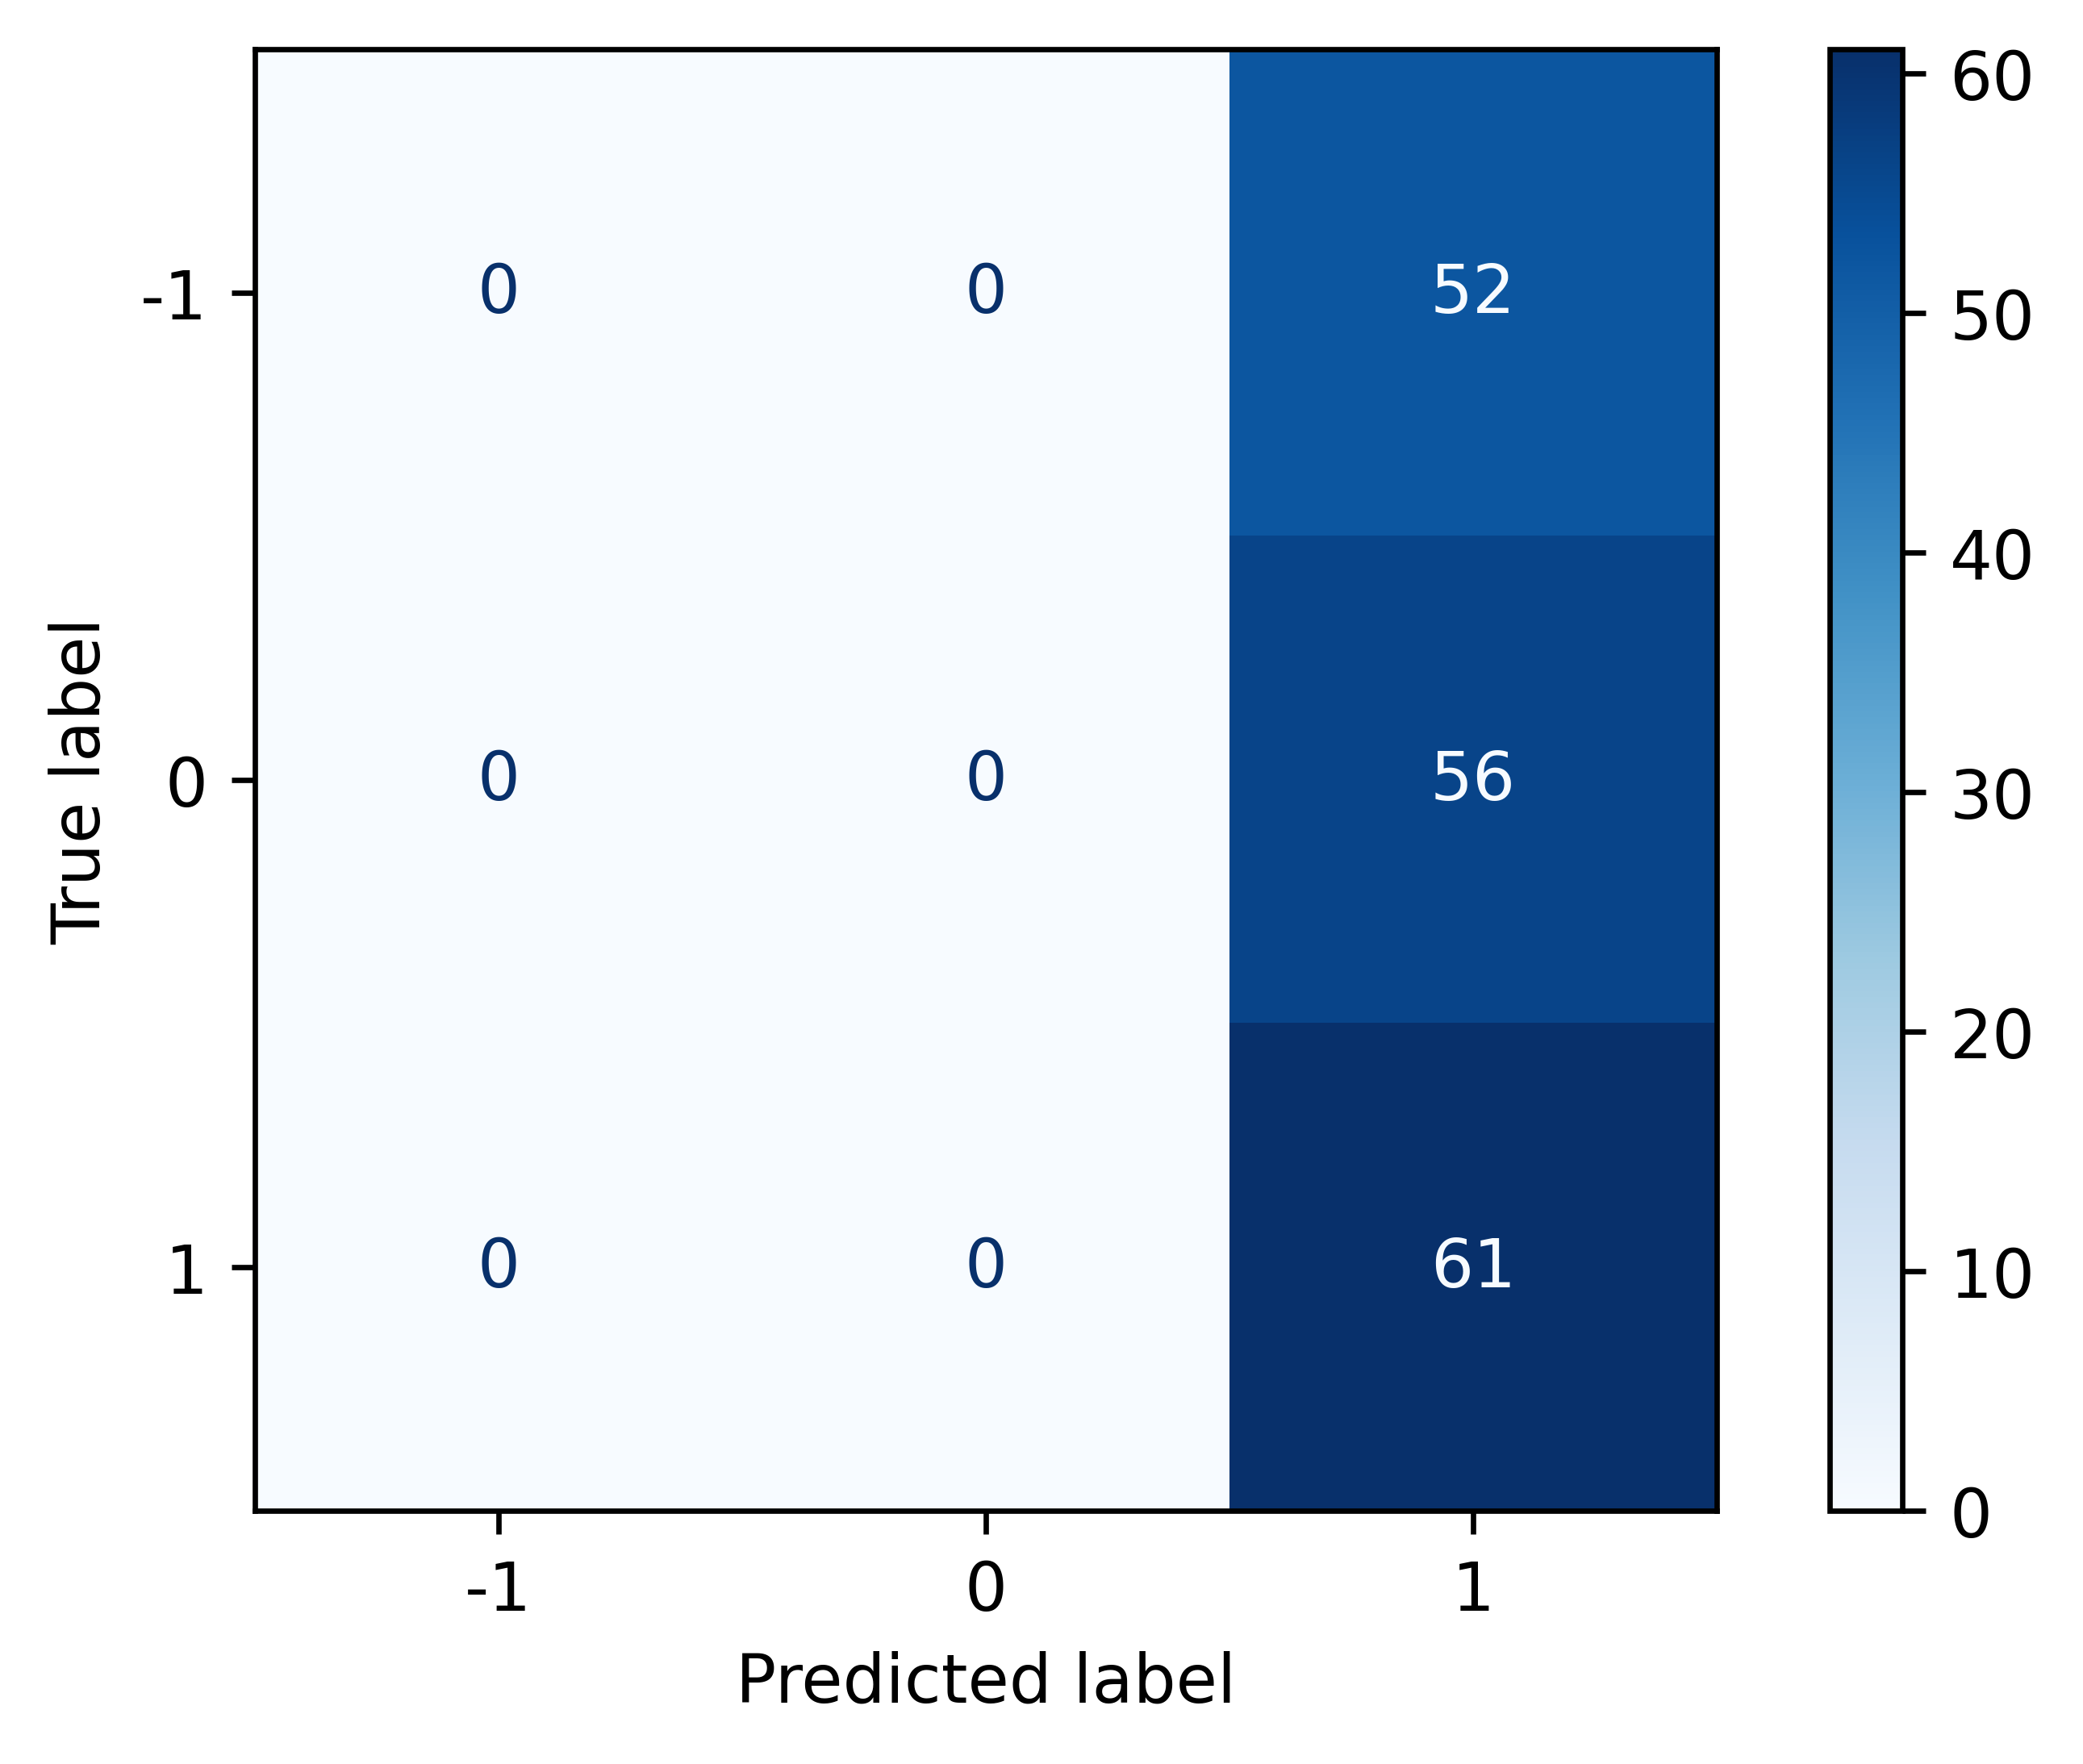

In [115]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    grid_search,
    X_test,
    y_test,
    display_labels=grid.classes_,
    cmap=plt.cm.Blues,
    
)


plt.show()

## Valence based classification

In [146]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_valence, speaker_identity, test_size=0.33, random_state=42)

In [147]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([38, 42, 43, 40, 46, 44, 47, 43])

In [148]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total.values()

dict_values([62, 116, 85, 80])

In [149]:
X_train_norm = (X_train - X_train.min(0)) / X_train.ptp(0)

In [150]:
X_test_norm = (X_test - X_test.min(0)) / X_test.ptp(0)

In [151]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [5,1,0.1,0.01,0.001,0.0001],
              'kernel': ['linear','rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [152]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [153]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 47.76%


In [154]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 40.24%


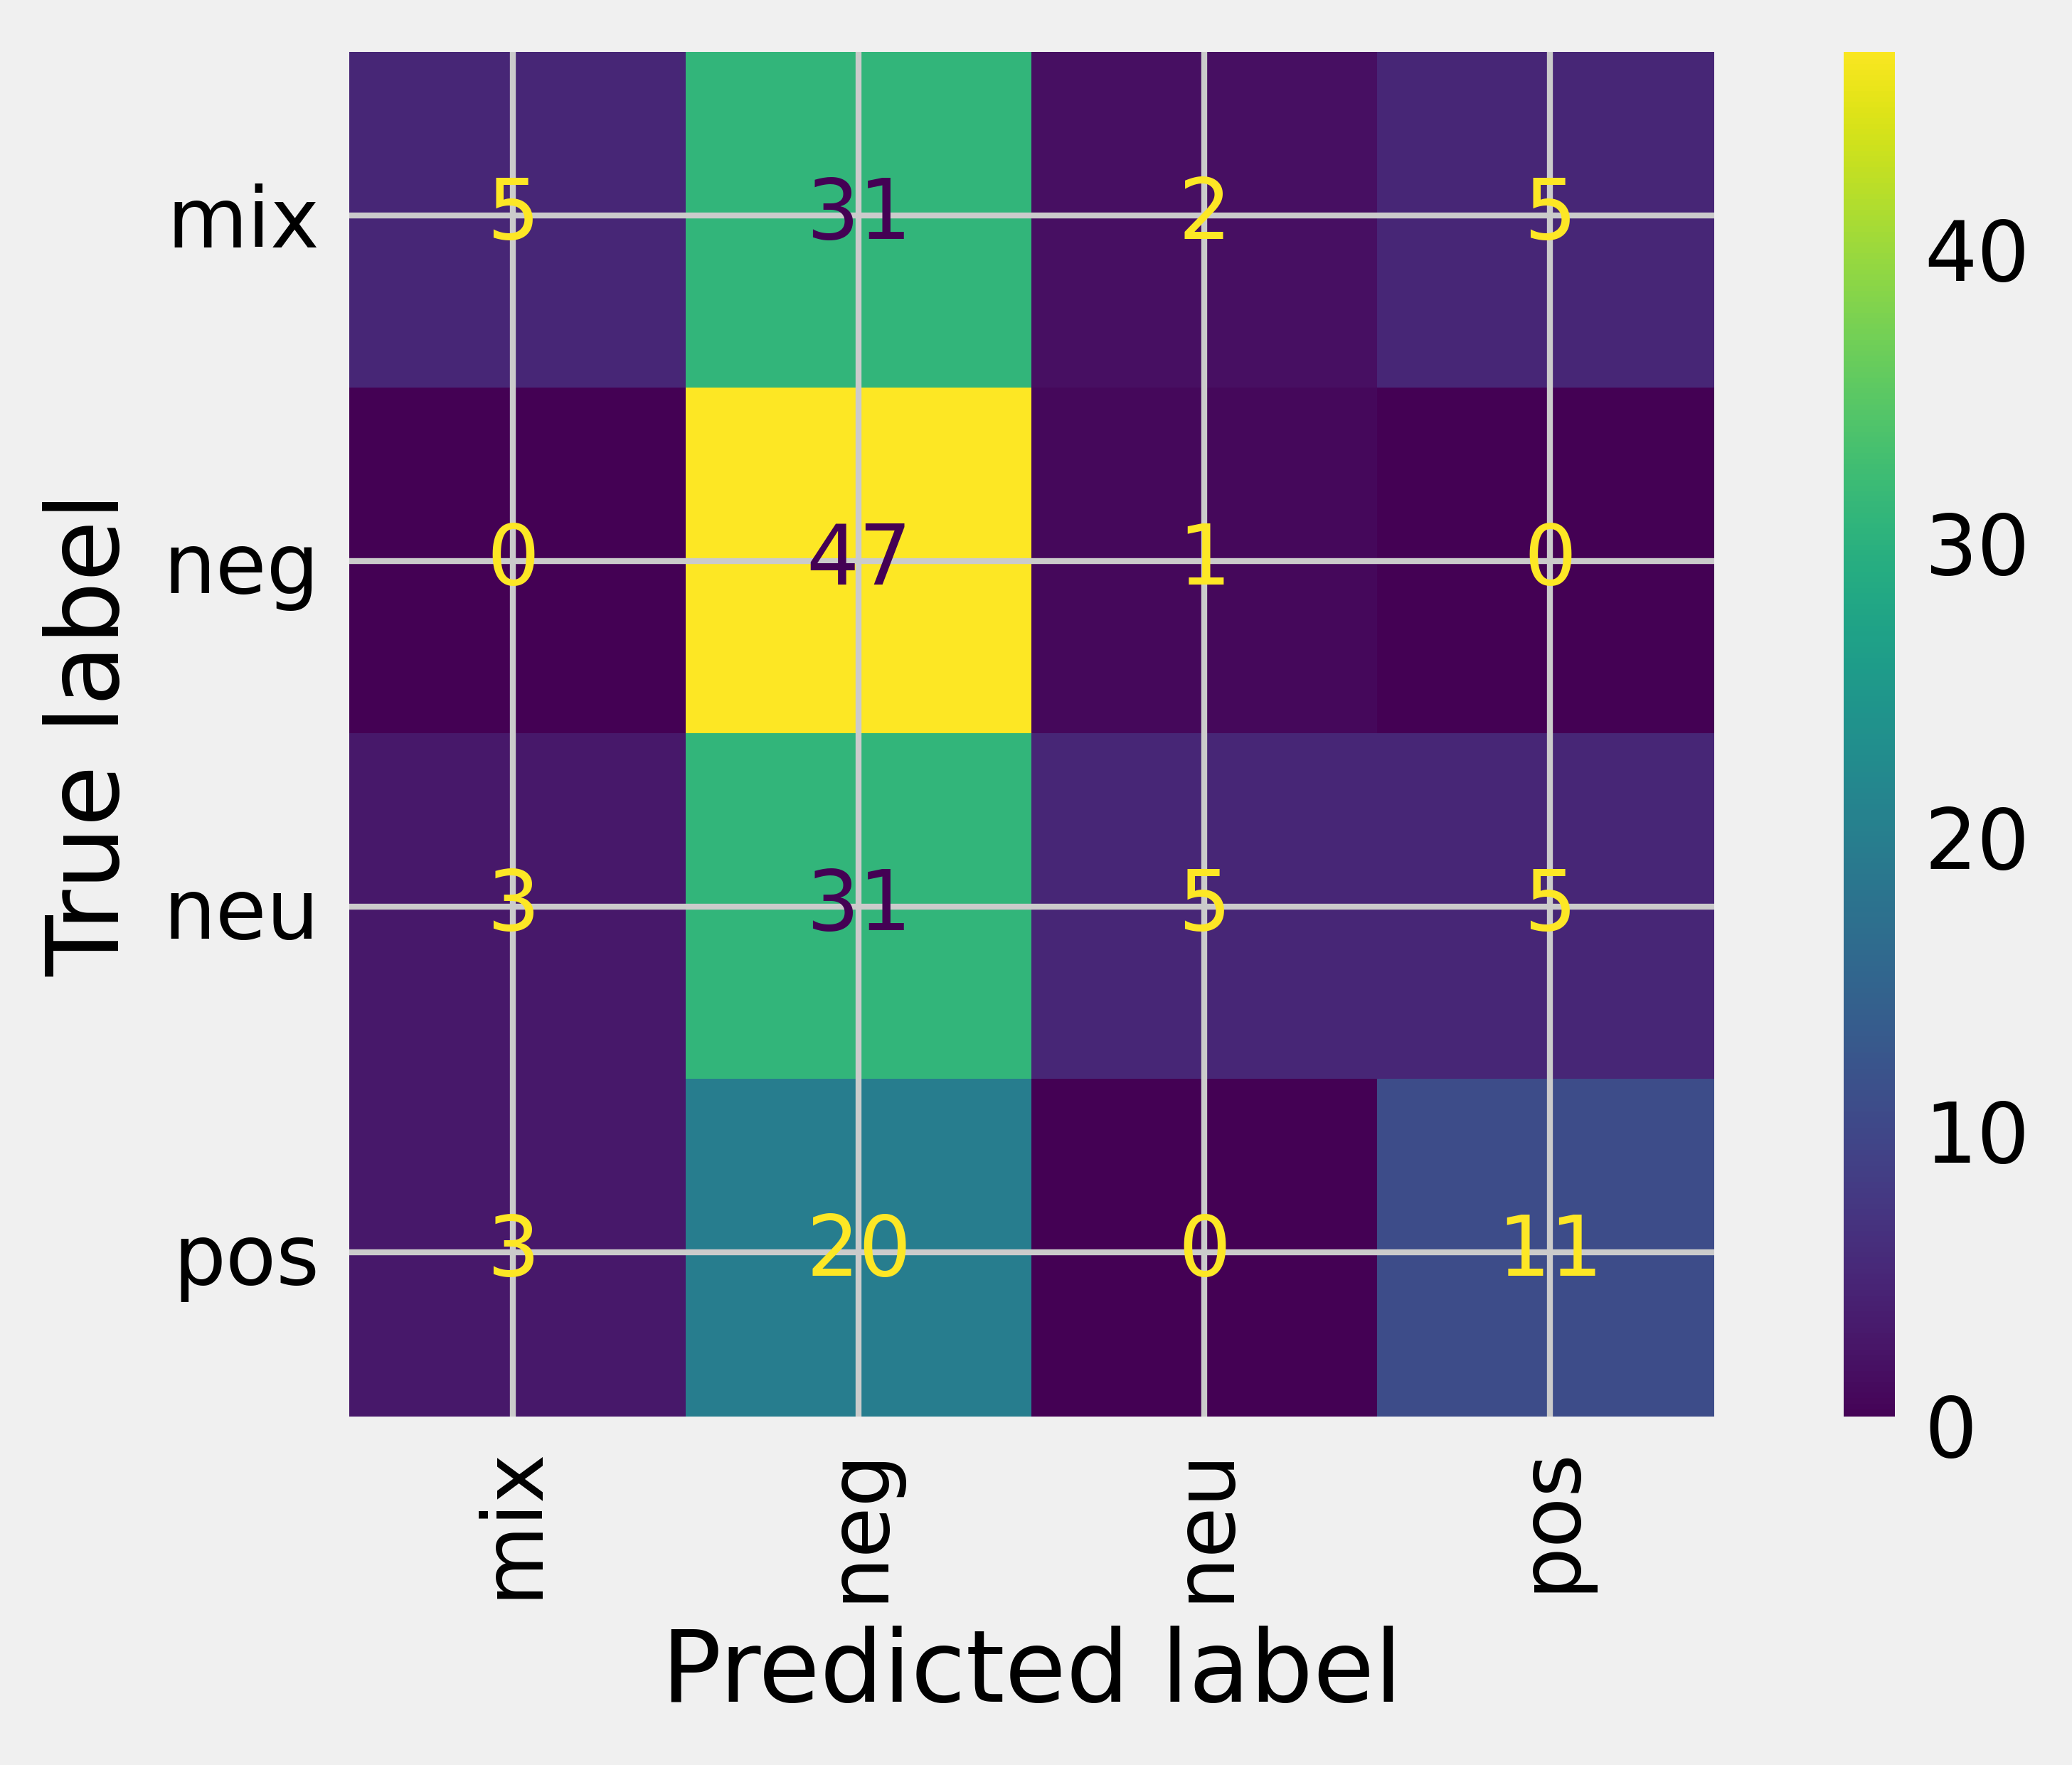

In [155]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [169]:
X.shape

(512, 88)

## Dominance based classification

In [182]:
X_train, X_test, y_train, y_test, speaker_identity_train, speaker_identity_test = train_test_split(X, y_dominance, speaker_identity, test_size=0.33, random_state=42)

In [176]:
speaker_hist = dict(collections.Counter(speaker_identity))
speaker_hist.values()

dict_values([64, 64, 64, 64, 64, 64, 64, 64])

In [180]:
emo_hist_total =  dict(collections.Counter(y_dominance))
emo_hist_total

{0: 224, 1: 96, -1: 192}

In [177]:
speaker_hist_train = dict(collections.Counter(speaker_identity_train))
speaker_hist_train.values()

dict_values([43, 43, 42, 43, 43, 43, 43, 43])

In [181]:
emo_hist_total =  dict(collections.Counter(y_train))
emo_hist_total

{-1: 131, 0: 144, 1: 68}

In [166]:
emo_hist_total

{0: 149, -1: 136, 1: 58}

In [183]:
# X_train_norm = (X_train - X_train.min(0)) / X_train.ptp(0)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)

In [184]:
# X_test_norm = (X_test - X_test.min(0)) / X_test.ptp(0)
X_test_norm = scaler.transform(X_test)

In [ ]:
X_test_normh

In [185]:
from sklearn.model_selection import GridSearchCV

#Create a svm Classifier and hyper parameter tuning 
ml = svm.SVC() 
  
# defining parameter range
param_grid = {'C': [ 1, 10, 100, 1000,10000], 
              'gamma': [5,1,0.1,0.01,0.001,0.0001],
              'kernel': ['linear','rbf']} 
  
grid = GridSearchCV(ml, param_grid, refit = True, verbose = 1,cv=10)
  
# fitting the model for grid search
grid_search=grid.fit(X_train_norm, y_train)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


In [162]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [163]:
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Accuracy for our training dataset with tuning is : 57.67%


In [164]:
y_test_hat=grid.predict(X_test_norm)
test_accuracy=accuracy_score(y_test,y_test_hat)*100
test_accuracy
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

Accuracy for our testing dataset with tuning is : 44.38%


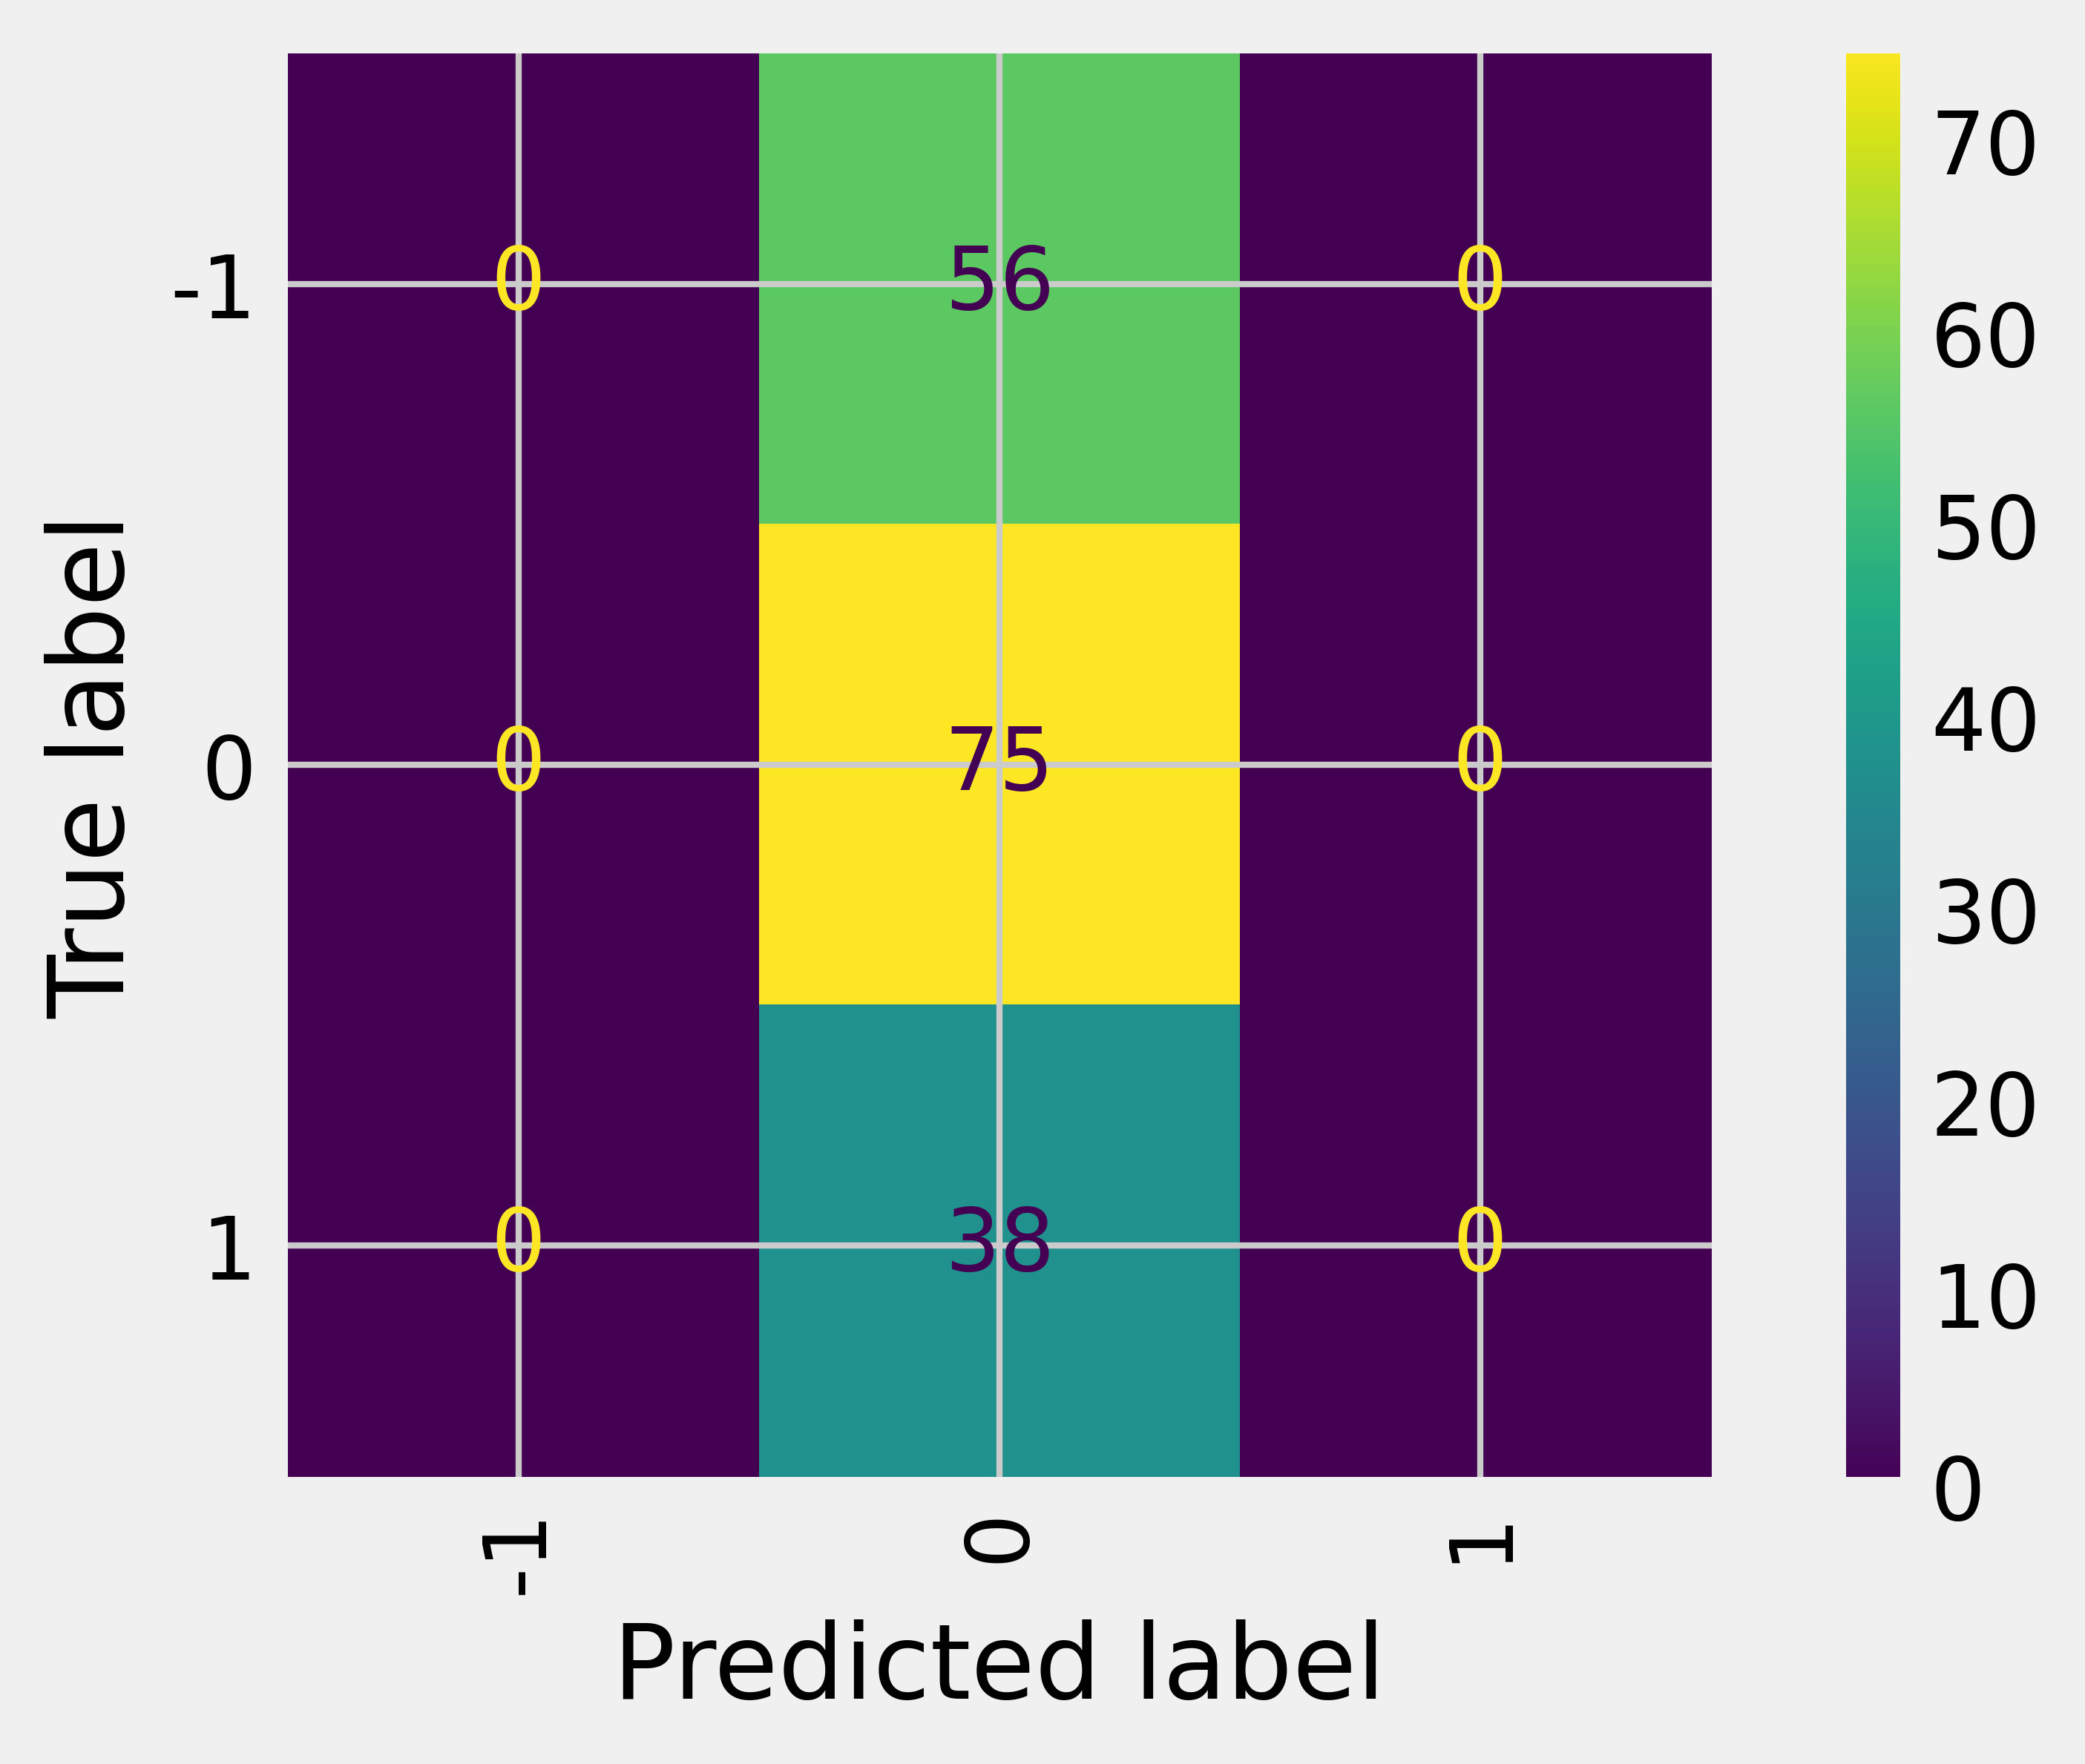

In [165]:
plt.rcParams['figure.dpi'] = 600
confusion_matrix(y_test,y_test_hat)
# disp=plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,y_test_hat), display_labels = grid.classes_)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [117]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_norm =  (X - X.min(0)) / X.ptp(0)
principalComponents = pca.fit_transform(X_norm)

principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i}' for i in range(1, 11)])

In [118]:
pca.explained_variance_ratio_

array([0.23367088, 0.17578806, 0.09928309, 0.05328591, 0.04788879,
       0.0389744 , 0.03050632, 0.02803552, 0.02320543, 0.02181   ],
      dtype=float32)

In [96]:
finalDf = principalDf.copy()

In [97]:
finalDf["target"] = y

In [98]:
import random
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(16)]

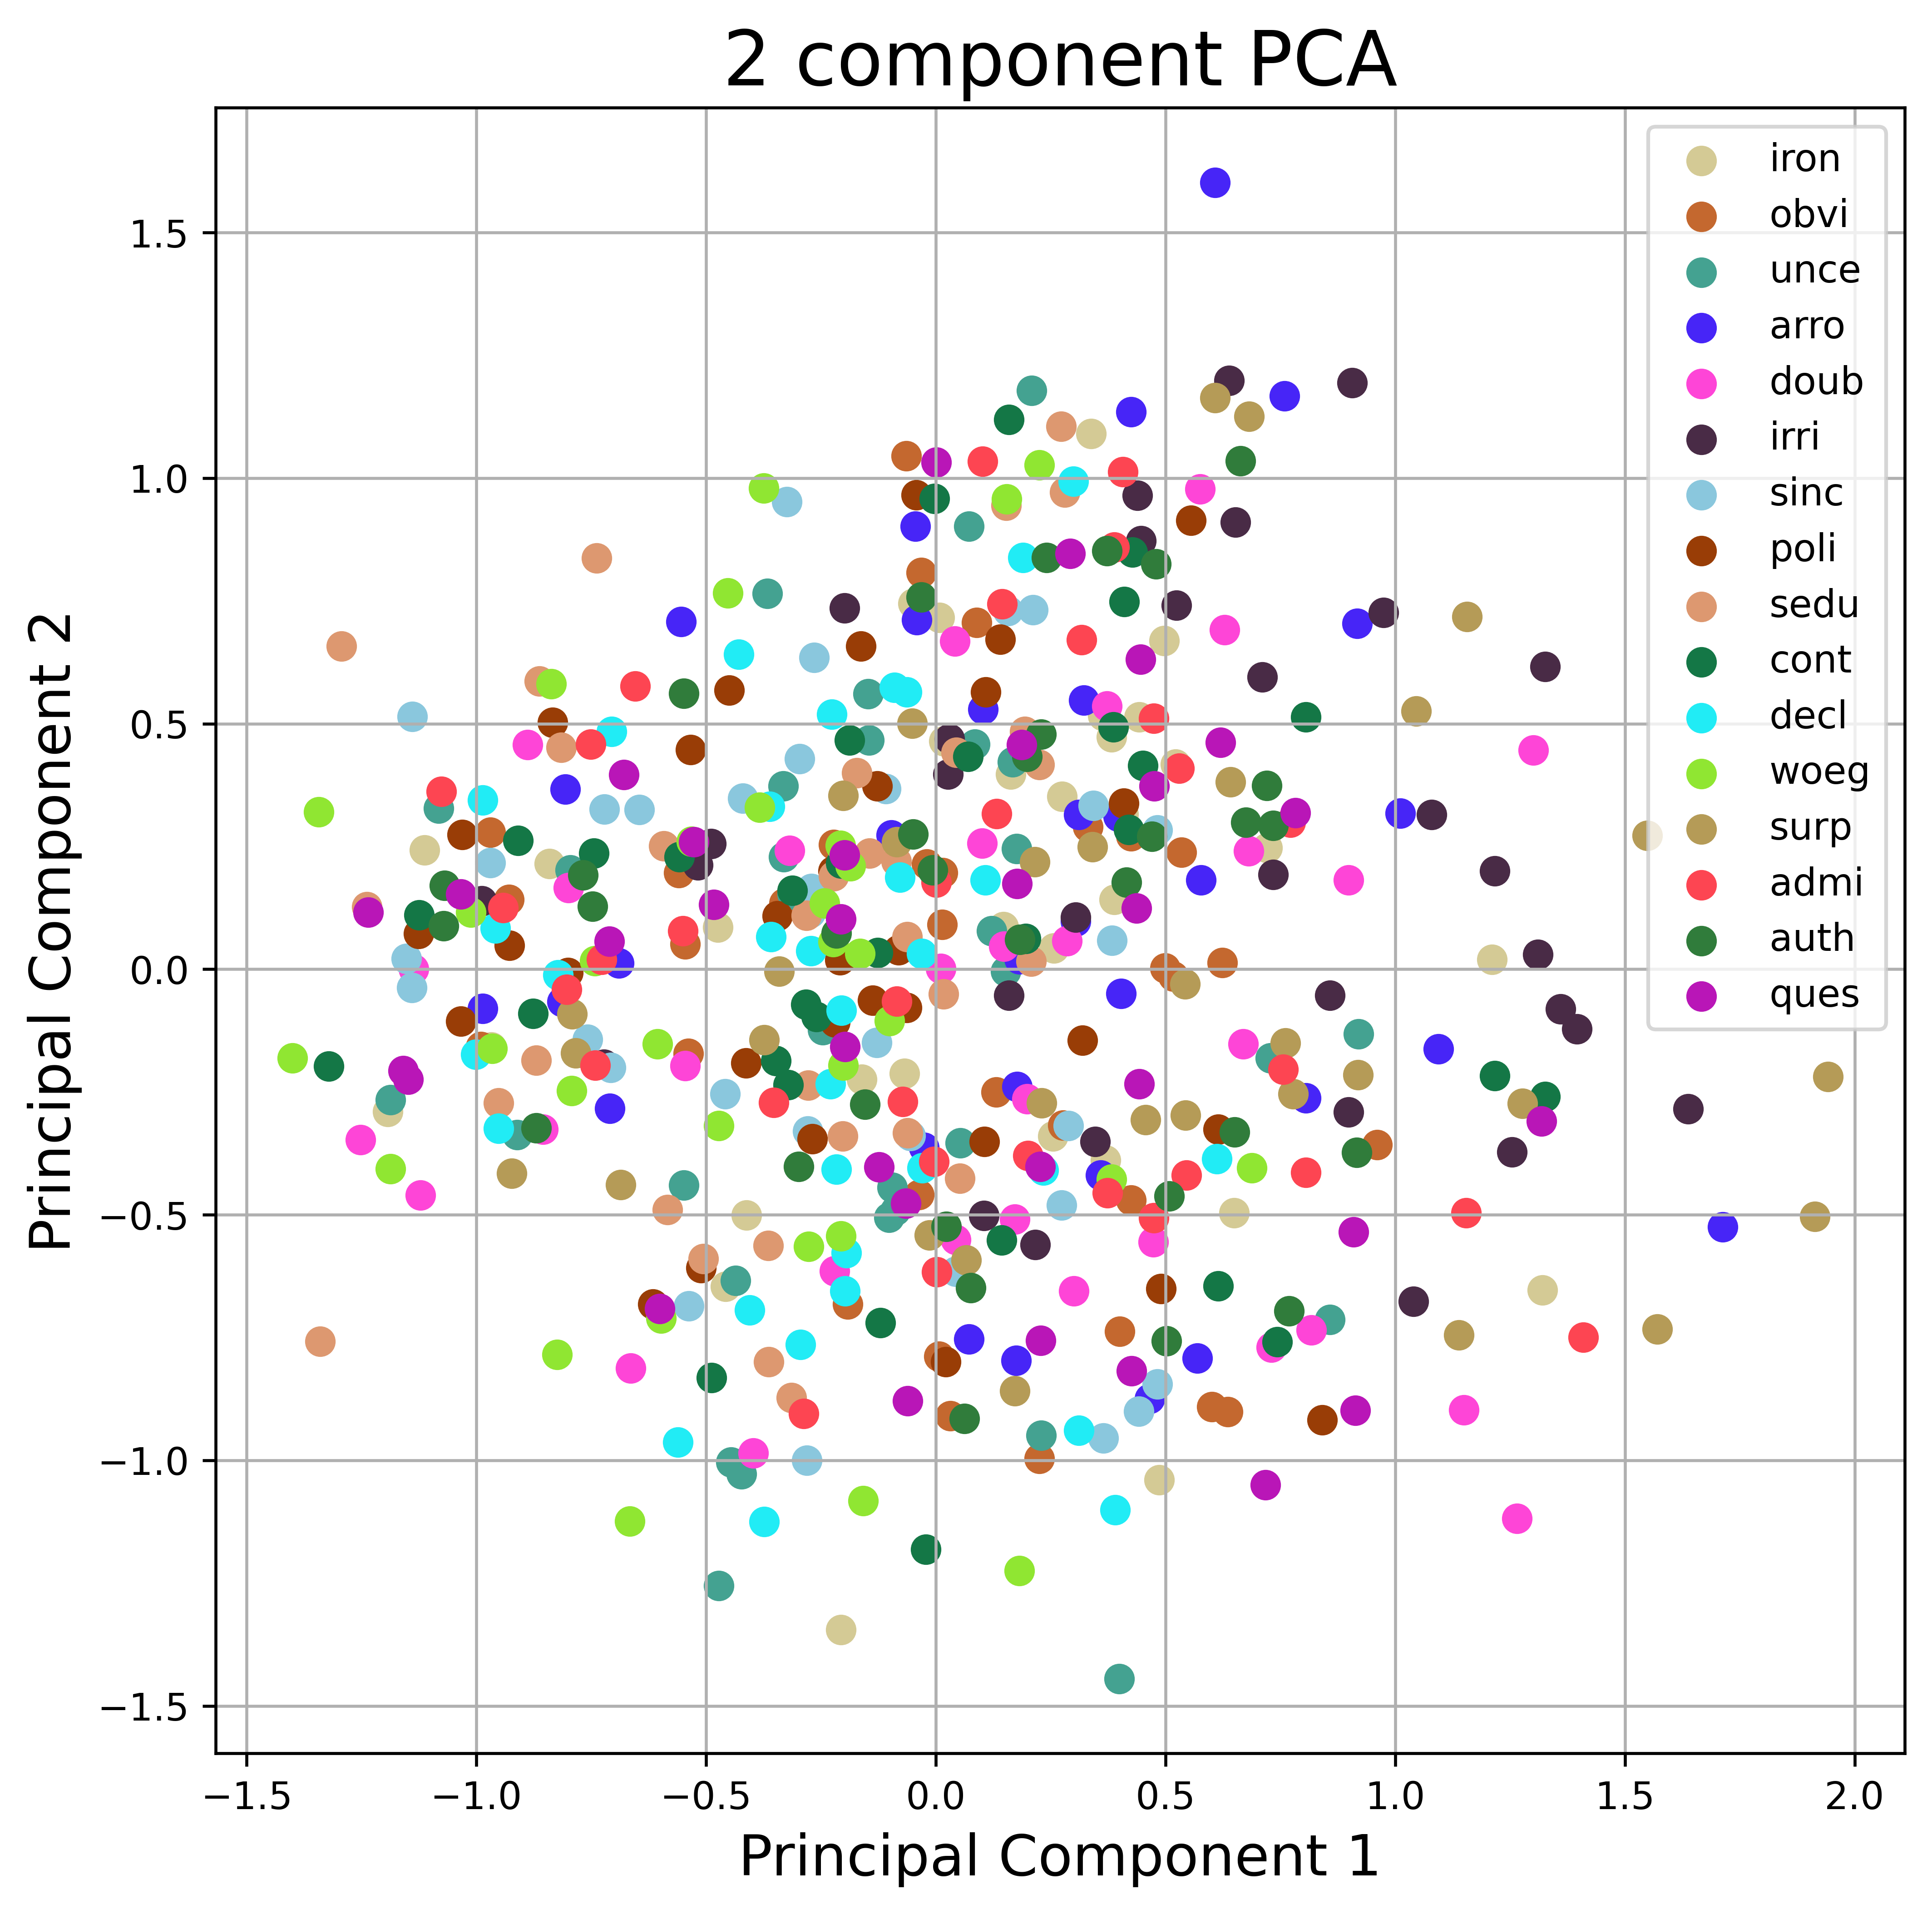

In [99]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = list(set(file_attitude))
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(16)]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [100]:
pca.explained_variance_ratio_

array([0.23367101, 0.1757881 ], dtype=float32)

In [101]:
from sklearn.cluster import KMeans

In [102]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10, max_iter=300, random_state=42)

In [103]:
kmeans.fit(X_norm)

KMeans(init='random', n_clusters=3, random_state=42)

In [104]:
kmeans.inertia_

645.1495971679688

In [107]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

sse = []
for k in range(1, 17):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_norm)
    sse.append(kmeans.inertia_)

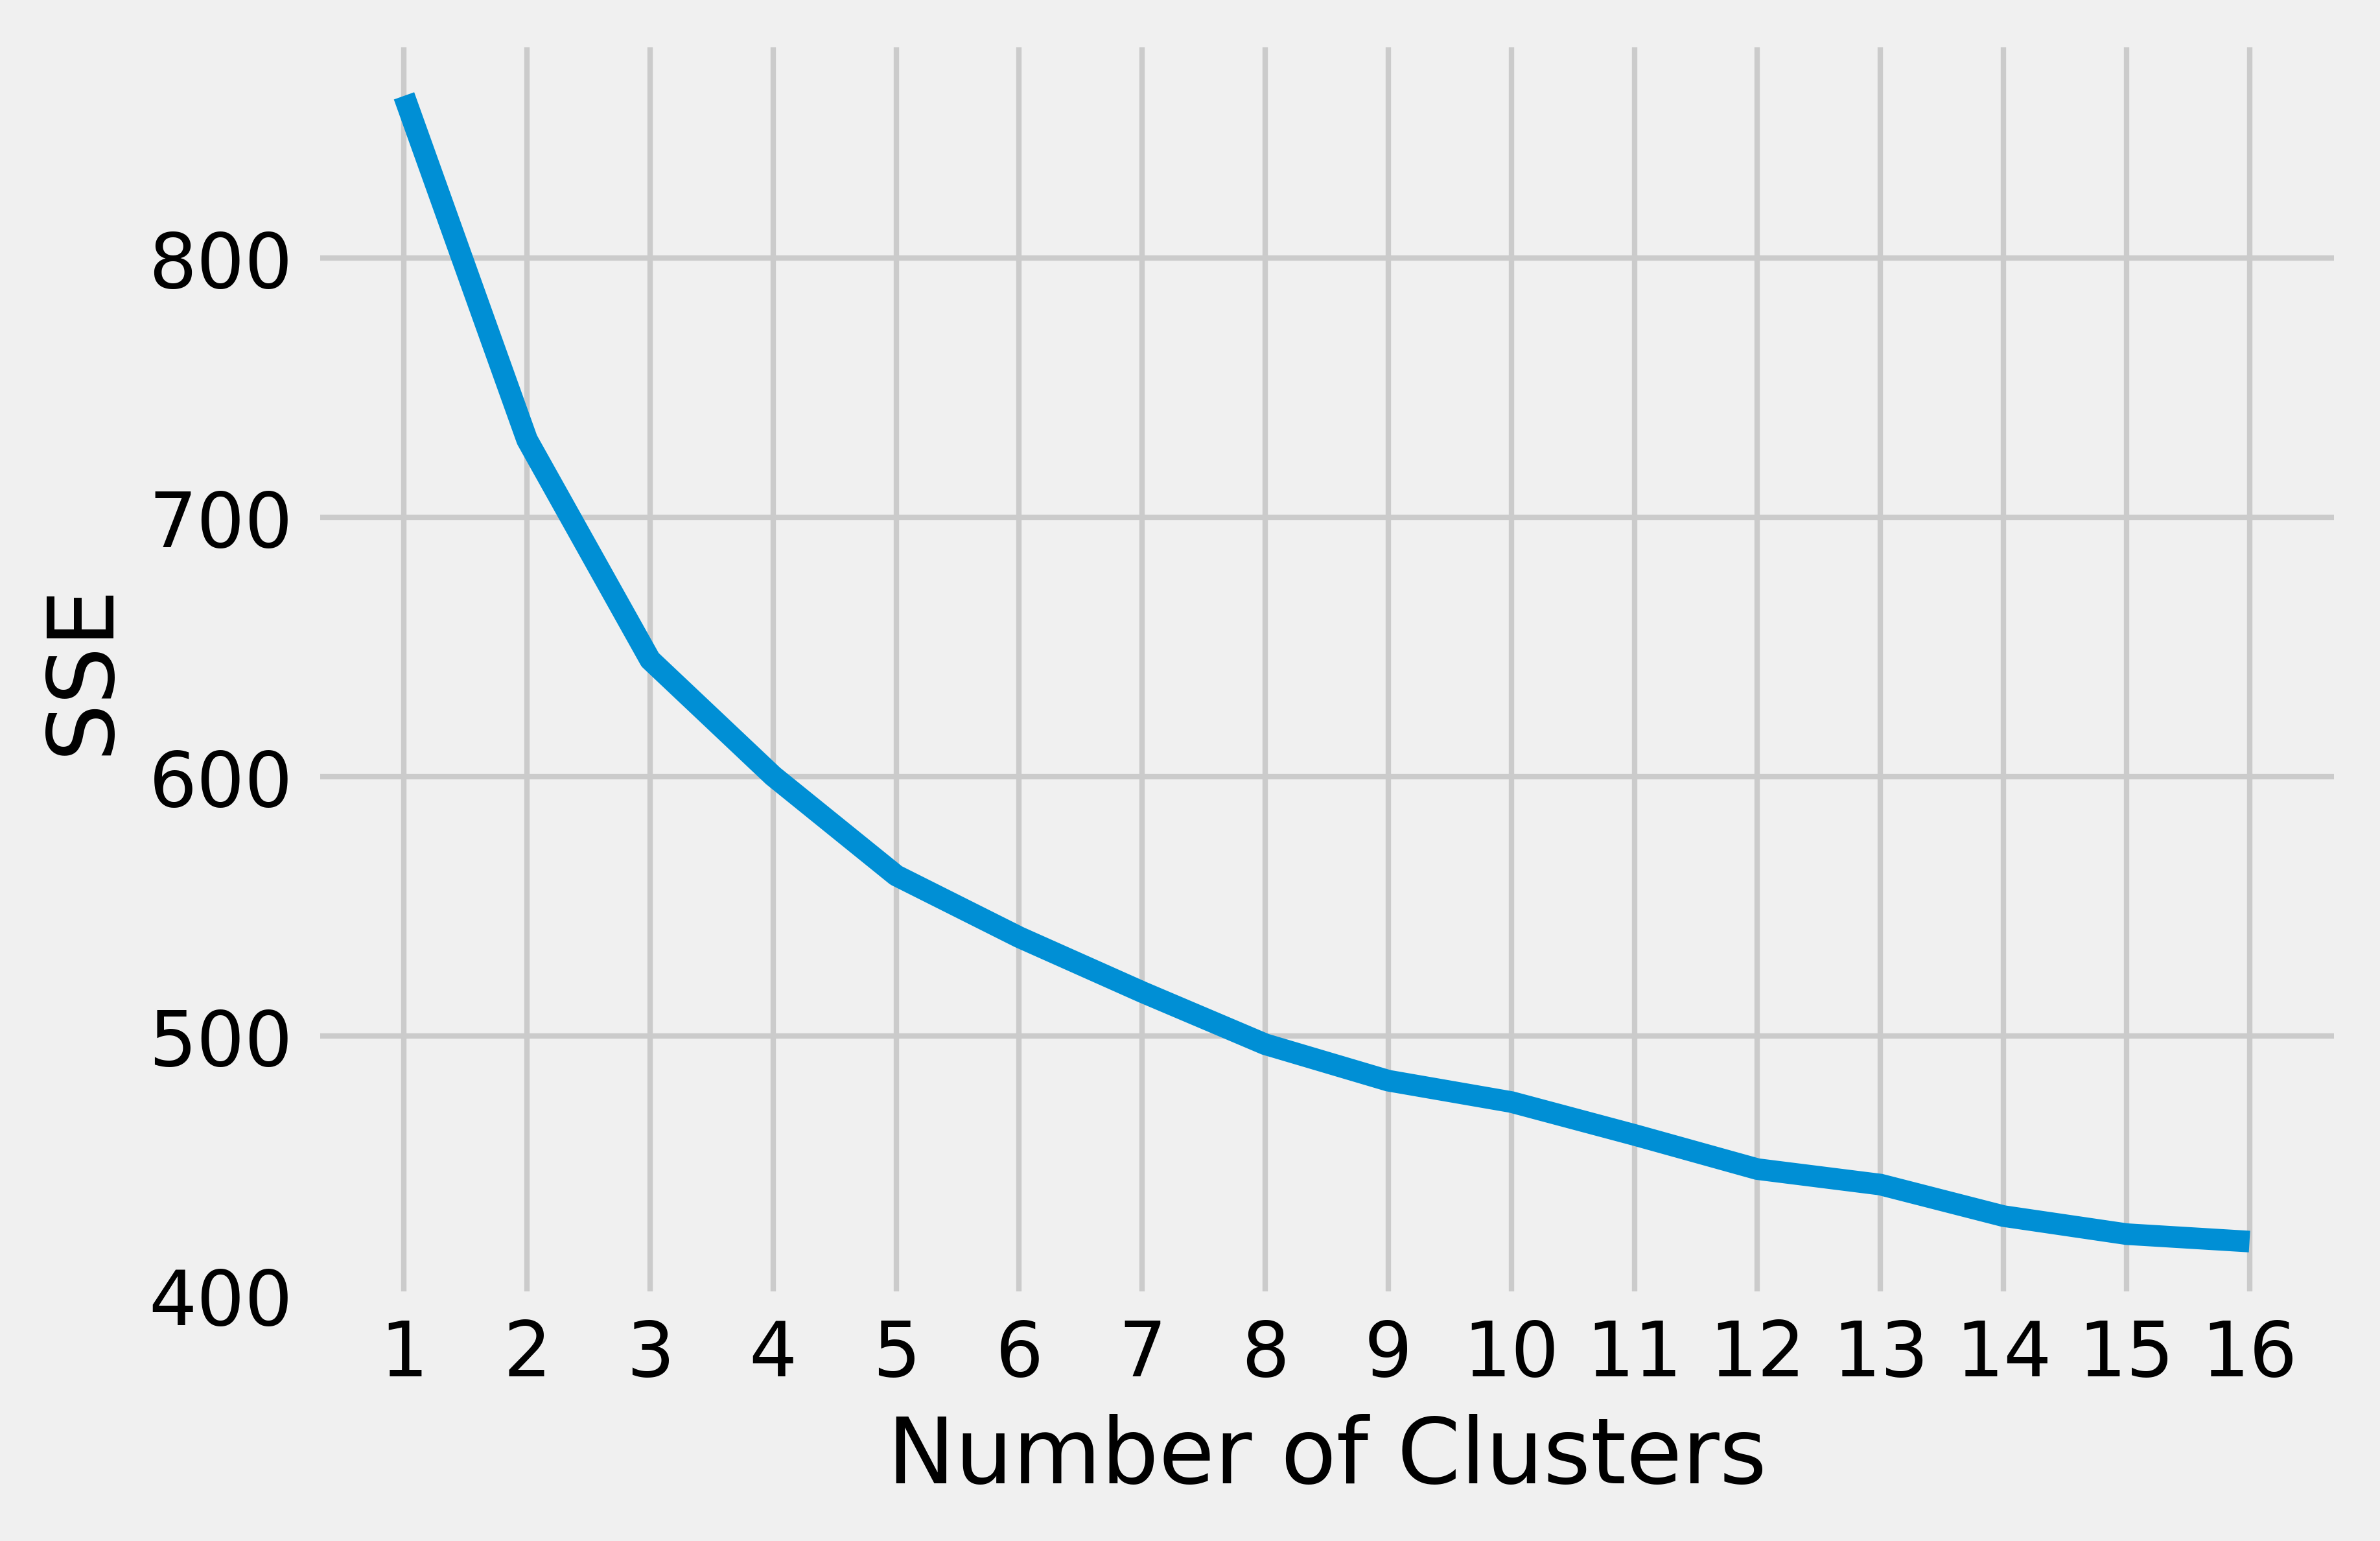

In [110]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 17), sse)
plt.xticks(range(1, 17))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [114]:
from sklearn.metrics import silhouette_score 
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 17):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_norm)
    score = silhouette_score(X_norm, kmeans.labels_)
    silhouette_coefficients.append(score)

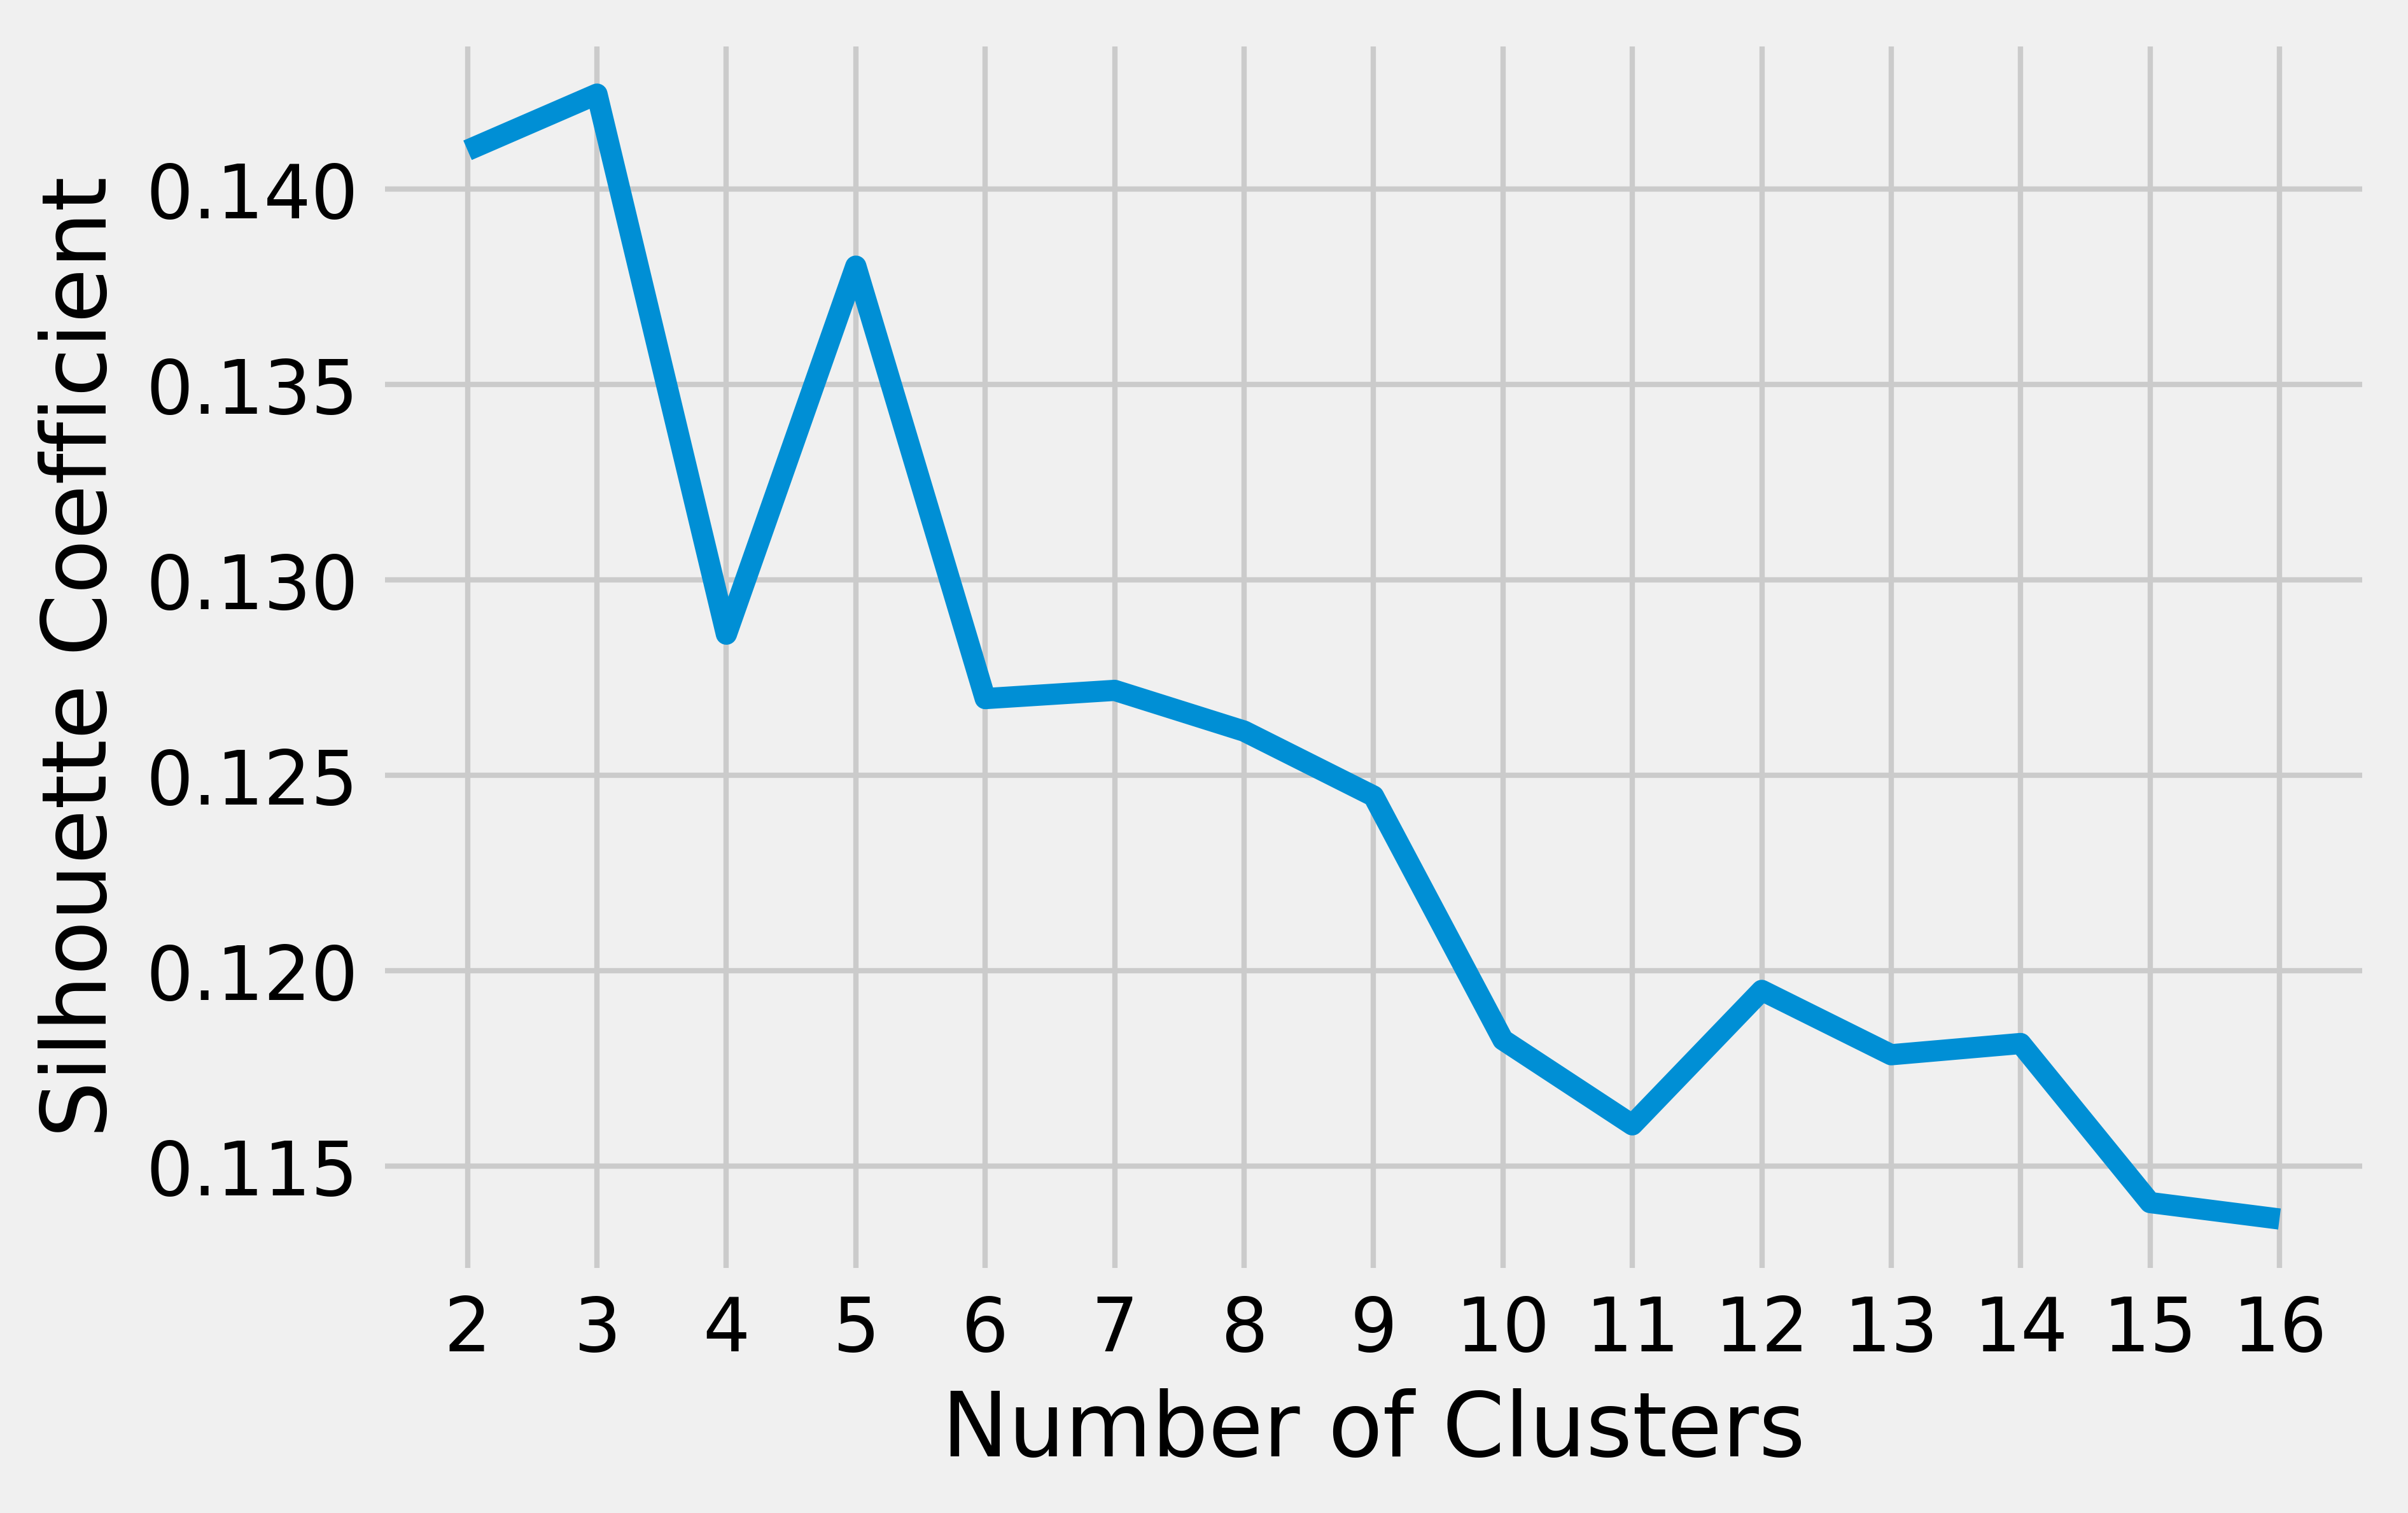

In [115]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 17), silhouette_coefficients)
plt.xticks(range(2, 17))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [120]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,0.144710,0.743846,-0.940469,-0.173804,-0.003259,0.227741,-0.006867,-0.173426,-0.036481,-0.096547
1,0.388403,0.859428,-0.581611,-0.087000,0.280458,-0.014749,0.348041,-0.143114,-0.006991,0.008725
2,0.474517,0.510298,-0.060575,-0.327145,0.331354,-0.204178,-0.182441,0.257389,-0.066741,-0.222365
3,0.772402,0.299341,0.063079,-0.540060,-0.294395,0.053171,0.020362,0.047637,-0.063345,-0.226215
4,0.424879,1.135164,-0.435597,-0.262819,0.313015,-0.142539,0.235045,-0.089985,0.142290,-0.417070
...,...,...,...,...,...,...,...,...,...,...
507,-1.186368,-0.266052,0.263624,0.191431,-0.085861,0.167863,0.160063,0.117279,-0.065159,0.009769
508,-1.012258,0.115928,-0.614546,0.167374,0.036657,-0.235158,0.067036,0.266818,-0.250681,-0.283595
509,-1.342780,0.320099,-0.429986,0.101384,-0.132697,-0.249286,0.104667,0.272030,-0.045411,-0.269537
510,-1.186498,-0.406746,0.036283,0.209141,0.041783,0.417912,0.116182,0.142754,0.008600,0.014616
